## Heuristic 4 - Multi-denomination deposit and withdraws linking

### Description
If there are multiple (say 12) deposit transactions coming from a deposit address and later there are 12 withdraw transactions to the same withdraw address, then we can link all these deposit transactions to the withdraw transactions.

In [1]:
# Import relevant packages.
import os, json
import itertools
from typing import Any, Tuple, List, Set, Dict, Optional

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

In [2]:
save_dir = "../data"
MIN_CONF: float = 0.2

In [3]:
clusters_file: str = os.path.join(save_dir, f'heuristic_4_clusters.json')
tx2addr_file: str = os.path.join(save_dir, f'heuristic_4_tx2addr.json')
addr2conf_file: str = os.path.join(save_dir, f'heuristic_4_addr2conf.json')
address_file: str = os.path.join(save_dir, f'heuristic_4_address_sets.json')
tornado_addrs_file: str = os.path.join(save_dir, f'tornado_pools.json')

In [4]:
def load_data(root) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    withdraw_df: pd.DataFrame = pd.read_csv(
        os.path.join(root, 'lighter_complete_withdraw_txs.csv'))

    # Change recipient_address to lowercase.
    withdraw_df['recipient_address'] = withdraw_df['recipient_address'].str.lower()
    
    # Change block_timestamp field to be a timestamp object.
    withdraw_df['block_timestamp'] = withdraw_df['block_timestamp'].apply(pd.Timestamp)

    deposit_df: pd.DataFrame = pd.read_csv(
        os.path.join(root, 'lighter_complete_deposit_txs.csv'))
    
    # Change block_timestamp field to be a timestamp object.
    deposit_df['block_timestamp'] = deposit_df['block_timestamp'].apply(pd.Timestamp)

    # Load TCash pool addresses data
    with open(tornado_addrs_file) as json_file:
        tornado_addresses = json.load(json_file)
        
    withdraw_counts: Dict[str, int] = \
        withdraw_df.recipient_address.value_counts().to_dict()
    deposit_counts: Dict[str, int] = \
        deposit_df.from_address.value_counts().to_dict()

    withdraw_counts: pd.Series = \
        withdraw_df.recipient_address.apply(lambda x: withdraw_counts[x])
    deposit_counts: pd.Series = \
        deposit_df.from_address.apply(lambda x: deposit_counts[x])
    
    withdraw_df['tx_counts'] = withdraw_counts
    deposit_df['tx_counts'] = deposit_counts
    deposit_df["tcash_pool"] = deposit_df["tornado_cash_address"].apply(lambda addr: tornado_addresses[addr])


    # Remove withdraw and deposit transactions with only 1 or 2 transactions
    withdraw_df: pd.DataFrame = withdraw_df[withdraw_df.tx_counts > 2]
    deposit_df: pd.DataFrame = deposit_df[deposit_df.tx_counts > 2]

    return withdraw_df, deposit_df, tornado_addresses

### Docs: compare_transactions
Given two dictionaries, withdraw_dict and deposit_dict representing 
the total deposits and withdraws made by an address to each TCash pool, 
respectively, compares if the set of keys of both are equal and when 
they are, checks if all values in the deposit dictionary are equal or 
greater than each of the corresponding values of the withdraw 
dicionary. If this is the case, returns True, if not, False.

In [5]:
def compare_transactions(
    withdraw_counts_dict: pd.DataFrame, 
    deposit_dict: pd.DataFrame,
) -> bool:
    if set(withdraw_counts_dict.keys()) != set(deposit_dict.keys()):
        return False
    for currency in withdraw_counts_dict.keys():
        if not (len(deposit_dict[currency]) >= withdraw_counts_dict[currency]):
            return False
    return True

def diff_transactions(
    withdraw_counts_dict: pd.DataFrame, 
    deposit_dict: pd.DataFrame,
) -> int:
    num_diff: int = 0
    for currency in withdraw_counts_dict.keys():
        num_diff += abs(len(deposit_dict[currency]) - withdraw_counts_dict[currency])
    return num_diff

### Docs: get_num_of_withraws
Given a particular withdraw transaction and the withdraw transactions 
DataFrame, gets the total withdraws the address made in each pool. It 
is returned as a dictionary with the pools as the keys and the number 
of withdraws as the values.


In [6]:
def get_num_of_withdraws(
    withdraw_tx: pd.Series, 
    withdraw_df: pd.DataFrame, 
    tornado_addresses: Dict[str, str],
) -> Tuple[Dict[str, int], Dict[str, List[str]]]:

    cur_withdraw_pool: str = tornado_addresses[withdraw_tx.tornado_cash_address]

    withdraw_txs: Dict[str, List[str]] = {
        tornado_addresses[withdraw_tx.tornado_cash_address]: []}

    subset_df: pd.DataFrame = withdraw_df[
        (withdraw_df.recipient_address == withdraw_tx.recipient_address) & 
        (withdraw_df.block_timestamp <= withdraw_tx.block_timestamp) & 
        (withdraw_df.hash != withdraw_tx.hash)
    ]
    subset_df.loc[:, ('tornado_pool')] = subset_df.tornado_cash_address.map(
        lambda x: tornado_addresses[x])

    withdraw_count: pd.DataFrame = subset_df.groupby('tornado_pool').size()
    withdraw_count: Dict[str, int] = withdraw_count.to_dict()

    withdraw_txs: pd.DataFrame = subset_df.groupby('tornado_pool')['hash'].apply(list)
    withdraw_txs: Dict[str, List[str]] = withdraw_txs.to_dict()

    # add 1 for current address
    if cur_withdraw_pool in withdraw_count:
        withdraw_count[cur_withdraw_pool] += 1
        withdraw_txs[cur_withdraw_pool].append(withdraw_tx.hash)
    else:
        withdraw_count[cur_withdraw_pool] = 1
        withdraw_txs[cur_withdraw_pool] = [withdraw_tx.hash]

    return withdraw_count, withdraw_txs

In [7]:
def get_same_or_more_num_of_deposits(
    withdraw_counts: pd.DataFrame, 
    addr2deposit: Dict[str, Dict[str, List[str]]], 
) -> Tuple[List[str], Dict[str, float]]:
    
    conf_mapping: Dict[str, float] = dict()
    for address, deposits in addr2deposit.items():
        if compare_transactions(withdraw_counts, deposits):
            num_diff: int = diff_transactions(withdraw_counts, deposits)
            if num_diff == 0:
                conf: float = 1.0
            else:
                conf: float = 1. / num_diff
            conf_mapping[address] = conf

    return conf_mapping

### Docs: get_address_deposits

Given the deposit transactions DataFrame, returns a 
dictionary with every address to the transactions they
    deposited.
```
    Example:
    {
        '0x16e54b35d789832440ab47ae765e6a8098280676': 
            {
                '0.1 ETH': [...],
                '100 USDT': [...],
            },
        '0x35dd029618f4e1835008da21fd98850c776453f0': {
            '0.1 ETH': [...],
        },
        '0xe906442c11b85acbc58eccb253b9a55a20b80a56': {
            '0.1 ETH': [...],
        },
        '0xaf301de836c81deb8dff9dc22745e23c476155b2': {
            '1 ETH': [...],
            '0.1 ETH': [...],
            '10 ETH': [...],
        },
    }
```

In [8]:
def get_address_deposits(
    deposit_df: pd.DataFrame,
    tornado_addresses: Dict[str, int],
) -> Dict[str, Dict[str, List[str]]]:
    
    counts_df: pd.DataFrame = pd.DataFrame(
        deposit_df[['from_address', 'tornado_cash_address']].value_counts()
    ).rename(columns={0: "count"})
    
    addr2deposit: Dict[str, str] = {}
        
    print('Building map from address to deposits made by address...')
    for row in tqdm(counts_df.itertuples(), total=len(counts_df), mininterval=3):
        deposit_set: pd.Series = deposit_df[
            (deposit_df.from_address == row.Index[0]) &
            (deposit_df.tornado_cash_address == row.Index[1])
        ].hash
        deposit_set: Set[str] = list(set(deposit_set))

        if row.Index[0] in addr2deposit.keys():
            addr2deposit[row.Index[0]][
                tornado_addresses[row.Index[1]]] = deposit_set
        else:
            addr2deposit[row.Index[0]] = {
                tornado_addresses[row.Index[1]]: deposit_set}

    return addr2deposit

### Docs: get_same_num_of_transactions_heuristic
Given a withdraw tx and the deposit and withdraw data, returns a tuple consisting of `(False, None)` or `(True, response_dict)`:
* (False, None) is returned if there is no other withdraw with the same address or if it only made withdraws to one pool.
* (True, results_dict) is returned when withdraws with the same address as the current withdraw tx are found, and the withdraws were made to various pools. Results dict contains:
        * withdraw_txs: All the other withdraw txs linked to the current withdraw tx.
        * deposit_txs: All the deposit txs linked to the current withdraw tx.
        * deposit_confs: The confidence for each linked deposit address.
        * withdraw_addr: The address of the withdraw tx.
        * withdraw_tx2addr: A dictionary with the tx hash as key and the address as value
        * deposit_tx2addr: Same as above for deposits
        * privacy_score: Privacy score computed for the withdraw tx.

In [27]:
def same_num_of_transactions_heuristic(withdraw_tx: pd.Series, 
withdraw_df: pd.DataFrame, 
    addr2deposit: Dict[str, str], 
    tornado_addresses: Dict[str, int],
) -> Tuple[bool, Optional[Dict[str, Any]]]:
    
    # Calculate the number of withdrawals of the address 
    # from the withdraw_tx given as input.
    withdraw_counts, withdraw_set = get_num_of_withdraws(
        withdraw_tx, withdraw_df, tornado_addresses)

    # remove entries that only give to one pool, we are taking 
    # multi-denominational deposits only
    if len(withdraw_counts) == 1:
        return (False, None)

    withdraw_addr: str = withdraw_tx.recipient_address
    withdraw_txs: List[str] = list(itertools.chain(*list(withdraw_set.values())))
    withdraw_tx2addr = dict(zip(withdraw_txs, 
        [withdraw_addr for _ in range(len(withdraw_txs))]))

    # Based on withdraw_counts, the set of the addresses that have 
    # the same number of deposits is calculated.
    conf_map = get_same_or_more_num_of_deposits(withdraw_counts, addr2deposit)
    deposit_addrs : List[str] = list(conf_map.keys())
    deposit_confs: List[float] = [conf_map[addr] for addr in deposit_addrs]

    deposit_txs: List[str] = []
    deposit_tx2addr: Dict[str, str] = {}

    for address in deposit_addrs:
        deposit_set: Dict[str, List[str]] = addr2deposit[address]
        assert set(withdraw_set.keys()) == set(deposit_set.keys()), \
            "Set of keys do not match."

        address_conf: float = conf_map[address]

        if address_conf >= MIN_CONF:
            # list of all txs for withdraws and deposits regardless of pool
            cur_deposit_txs: List[str] = list(itertools.chain(*list(deposit_set.values())))

            # dictionary from transaction to address
            cur_deposit_tx2addr = dict(zip(cur_deposit_txs, 
                [address for _ in range(len(cur_deposit_txs))]))
            deposit_txs.extend(cur_deposit_txs)
            deposit_tx2addr.update(cur_deposit_tx2addr)

    if len(deposit_addrs) > 0:
        privacy_score: float = 1. - 1. / len(deposit_addrs)
        response_dict: Dict[str, Any] = dict(
            withdraw_txs = withdraw_txs,
            deposit_txs = deposit_txs,
            deposit_confs = deposit_confs,
            withdraw_addr = withdraw_addr,
            deposit_addrs = deposit_addrs,
            withdraw_tx2addr = withdraw_tx2addr,
            deposit_tx2addr = deposit_tx2addr,
            privacy_score = privacy_score,
        )
        return (True, response_dict)

    return (False, None)

### Docs: get_same_num_transactions_clusters
Using the multi-denomination heuristic, clusterize TCash deposit and withdraw transactions.
Returns clusters of linked txs and the compromised deposit txs

In [10]:
def get_same_num_transactions_clusters(
    deposit_df: pd.DataFrame, 
    withdraw_df: pd.DataFrame, 
    tornado_addresses: dict,
    data_dir: str,
):

    cached_addr2deposit: str =  os.path.join(data_dir, 'same_num_txs_addr2deposit.json')
    if os.path.isfile(cached_addr2deposit):
        print('Found cached deposit mapping: loading...')
        with open(cached_addr2deposit, 'r') as json_file:
            addr2deposit = json.load(json_file)
    else:
        addr2deposit = get_address_deposits(deposit_df, tornado_addresses)
        with open(cached_addr2deposit, "w") as outfile:
            json.dump(addr2deposit, outfile, indent=4)

    tx_clusters: List[Set[str]] = []
    tx2addr: Dict[str, str] = {}
    address_sets: List[Set[str]] = []
    addr2conf: Dict[Tuple[str, str], float] = {}
        
    compromised_deposits: Set[str] = set()

    print('Processing withdraws')
    for withdraw_row in tqdm(withdraw_df.itertuples(), total=len(withdraw_df), mininterval=5):
        results = same_num_of_transactions_heuristic(
            withdraw_row, withdraw_df, addr2deposit, tornado_addresses)

        if results[0]:
            response_dict = results[1]

            # populate graph with known transactions
            withdraw_txs: List[str] = response_dict['withdraw_txs']
            deposit_txs: List[str] = response_dict['deposit_txs']
            withdraw_tx2addr: Dict[str, str] = response_dict['withdraw_tx2addr']
            deposit_tx2addr: Dict[str, str] = response_dict['deposit_tx2addr']
            tx_cluster: Set[str] = set(withdraw_txs + deposit_txs)

            withdraw_addr: str = response_dict['withdraw_addr']
            deposit_addrs: List[str] = response_dict['deposit_addrs']
            deposit_confs: List[float] = response_dict['deposit_confs']

            for deposit_addr, deposit_conf in zip(deposit_addrs, deposit_confs):
                if withdraw_addr != deposit_addr:
                    address_sets.append([withdraw_addr, deposit_addr])
                    addr2conf[(withdraw_addr, deposit_addr)] = deposit_conf

            tx2addr.update(withdraw_tx2addr)
            tx2addr.update(deposit_tx2addr)
            tx_clusters.append(tx_cluster)
            
            compromised_deposits.update(deposit_txs)

    return tx_clusters, address_sets, tx2addr, addr2conf, compromised_deposits

In [11]:
withdraw_txs, deposit_txs, tornado_addresses = load_data(save_dir)

In [28]:
clusters, address_sets, tx2addr, addr2conf, compromised_deposits = get_same_num_transactions_clusters(
    deposit_txs, withdraw_txs, tornado_addresses, save_dir)

Found cached deposit mapping: loading...
Processing withdraws


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53485/53485 [11:07<00:00, 80.08it/s]


### Results exploration

In [13]:
address_sets_df = pd.DataFrame(address_sets, columns=["withdraw", "deposit"])

In [14]:
waddr2daddr = dict(address_sets_df.groupby("withdraw")["deposit"].apply(list))

In [15]:
linked_addr_counts = [len(daddrs_list) for _, daddrs_list in waddr2daddr.items()]

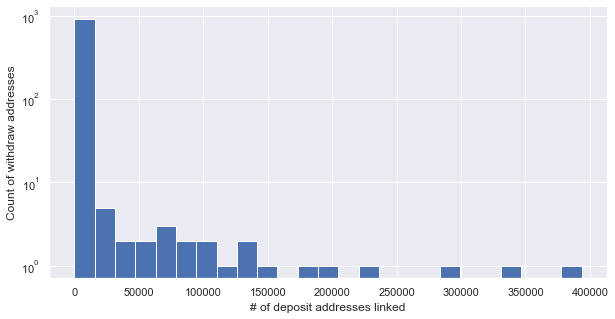

In [16]:
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(linked_addr_counts, bins=25)
ax.set_yscale("log")
ax.set_xlabel("# of deposit addresses linked")
ax.set_ylabel("Count of withdraw addresses")
plt.show()

In [17]:
def tx2pool(txs_df):
    tx_to_pool_dict = {}
    for row in tqdm(txs_df.itertuples(), mininterval=1):
        tx_to_pool_dict[row.hash] = row.tcash_pool
    
    return tx_to_pool_dict

In [18]:
d2pool_dict = tx2pool(deposit_txs)

78323it [00:00, 222131.03it/s]


In [19]:
flat_compromised_deposits = list(compromised_deposits)

In [20]:
#compromised_deposit_hashes = set(list(itertools.chain(*w2d.values())))
number_of_compromised_deposits_by_pool = Counter(list(map(lambda x: d2pool_dict[x], flat_compromised_deposits)))

In [21]:
pools_to_deposits = dict(deposit_txs.groupby("tcash_pool")["hash"].apply(list))
number_of_uncompromised_deposits_by_pool = {}
for pool in list(pools_to_deposits.keys()):
    number_of_uncompromised_deposits_by_pool[pool] = len(pools_to_deposits[pool]) - number_of_compromised_deposits_by_pool[pool]

In [22]:
compromised_vs_uncompromised_by_pool = {}

for pool in list(number_of_compromised_deposits_by_pool.keys()):
    compromised_vs_uncompromised_by_pool[pool] = (number_of_compromised_deposits_by_pool[pool], number_of_uncompromised_deposits_by_pool[pool])

In [23]:
eth_pools = ["0.1 ETH", "1 ETH", "10 ETH", "100 ETH"]
tkn_pools = [pool for pool in compromised_vs_uncompromised_by_pool.keys() if pool not in eth_pools]
all_pools = eth_pools + tkn_pools

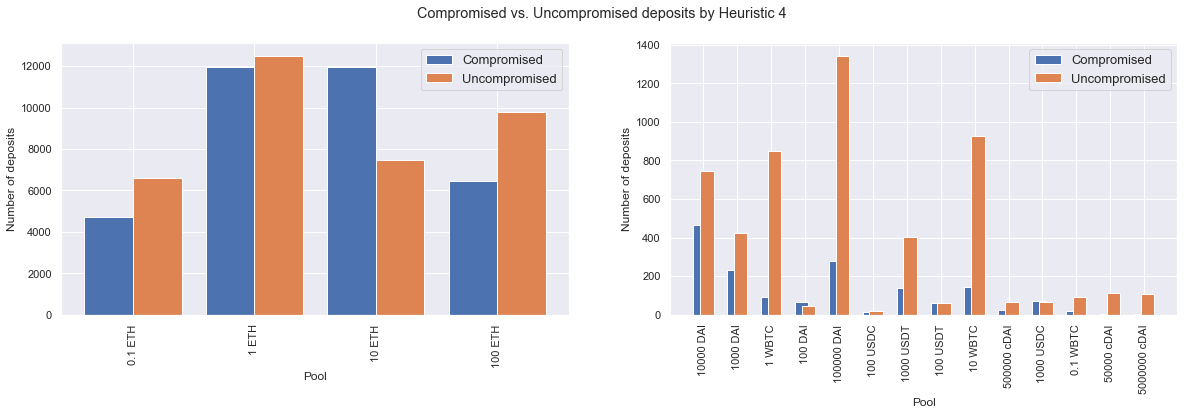

In [24]:
points = [compromised_vs_uncompromised_by_pool[pool] for pool in all_pools]

eth_compromised = [t[0] for t in points[:4]]
eth_uncompromised = [t[1] for t in points[:4]]
eth_x_axis = np.arange(len(eth_pools))

tkn_compromised = [t[0] for t in points[4:]]
tkn_uncompromised = [t[1] for t in points[4:]]
tkn_x_axis = np.arange(len(tkn_pools))

sns.set_theme(style="darkgrid")
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
ax1.bar(eth_x_axis - 0.2, eth_compromised, 0.4, label = "Compromised")
ax1.bar(eth_x_axis + 0.2, eth_uncompromised, 0.4, label = "Uncompromised")
ax1.set_xticks(eth_x_axis)
ax1.set_xticklabels(eth_pools, rotation="vertical")
ax1.set_xlabel("Pool")
ax1.set_ylabel("Number of deposits")
ax1.legend(fontsize=13)

ax2.bar(tkn_x_axis - 0.1, tkn_compromised, 0.4, label = "Compromised")
ax2.bar(tkn_x_axis + 0.1, tkn_uncompromised, 0.4, label = "Uncompromised")
ax2.set_xticks(tkn_x_axis)
ax2.set_xticklabels(tkn_pools, rotation="vertical")
ax2.set_xlabel("Pool")
ax2.set_ylabel("Number of deposits")
ax2.legend(fontsize=13)
fig.suptitle("Compromised vs. Uncompromised deposits by Heuristic 4")

plt.show()

In [25]:
rate_compromised_vs_uncompromised_by_pool = {}
for pool in compromised_vs_uncompromised_by_pool.keys():
    n_compromised = compromised_vs_uncompromised_by_pool[pool][0]
    n_uncompromised = compromised_vs_uncompromised_by_pool[pool][1]
    total_deposits = n_compromised + n_uncompromised
    
    rate_compromised_vs_uncompromised_by_pool[pool] = (n_compromised/total_deposits * 100, n_uncompromised/total_deposits * 100)

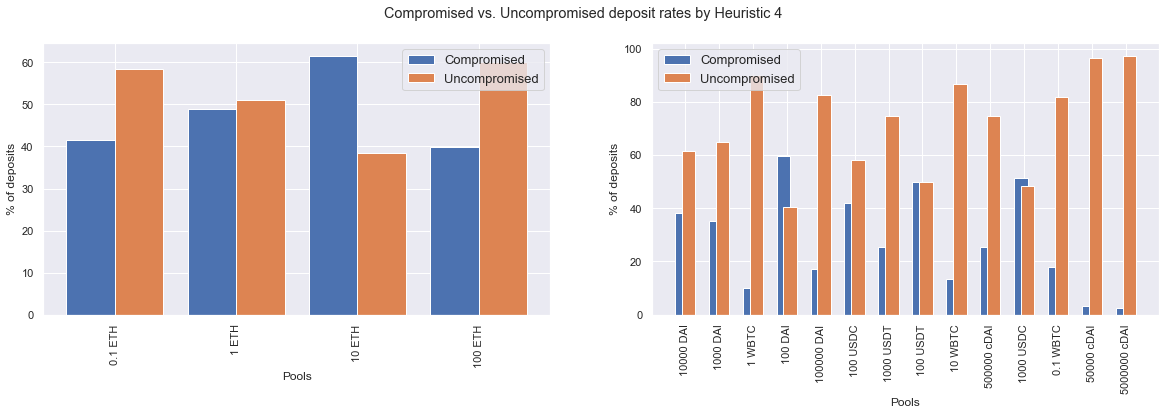

In [26]:
rate_points = [rate_compromised_vs_uncompromised_by_pool[pool] for pool in all_pools]

eth_compromised = [t[0] for t in rate_points[:4]]
eth_uncompromised = [t[1] for t in rate_points[:4]]
eth_x_axis = np.arange(len(eth_pools))

tkn_compromised = [t[0] for t in rate_points[4:]]
tkn_uncompromised = [t[1] for t in rate_points[4:]]
tkn_x_axis = np.arange(len(tkn_pools))


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
ax1.bar(eth_x_axis - 0.2, eth_compromised, 0.4, label = "Compromised")
ax1.bar(eth_x_axis + 0.2, eth_uncompromised, 0.4, label = "Uncompromised")
ax1.set_xticks(eth_x_axis)
ax1.set_xticklabels(eth_pools, rotation="vertical")
ax1.set_xlabel("Pools")
ax1.set_ylabel("% of deposits")
ax1.legend(fontsize=13)

ax2.bar(tkn_x_axis - 0.1, tkn_compromised, 0.4, label = "Compromised")
ax2.bar(tkn_x_axis + 0.1, tkn_uncompromised, 0.4, label = "Uncompromised")
ax2.set_xticks(tkn_x_axis)
ax2.set_xticklabels(tkn_pools, rotation="vertical")
ax2.set_xlabel("Pools")
ax2.set_ylabel("% of deposits")
ax2.legend(fontsize=13)
fig.suptitle("Compromised vs. Uncompromised deposit rates by Heuristic 4")

plt.show()